# Toy example

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import ndcg_score
from scipy.stats import kendalltau

acc_mean = 10
top = 100

# Generate data points within the range 0-1 by filtering
data = pd.DataFrame({'val_acc': np.random.exponential(acc_mean, top**2)})
data = data.loc[(data['val_acc']<100) & (data['val_acc']>0)]
data['random_rank'] = np.random.permutation(len(data)) + 1
data['perfect_rank'] = data['val_acc'].rank(ascending=True)
data['damaged_rank'] = data['perfect_rank']
top_indices = data['damaged_rank'].nlargest(top).index
data.loc[top_indices, 'damaged_rank'] = range(top, 0, -1)
data.loc[~data.index.isin(top_indices), 'damaged_rank'] += top 

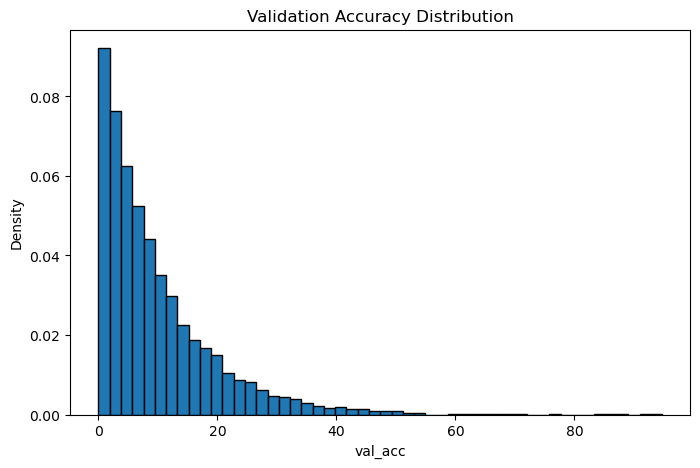

In [10]:
plt.figure(figsize=(8, 5))
plt.hist(data['val_acc'], bins=50, edgecolor="black", density=True)
plt.title("Validation Accuracy Distribution")
plt.xlabel("val_acc")
plt.ylabel("Density")
plt.savefig('example_bad_kendall.eps', format='eps')
plt.show()
plt.close()

In [210]:
table = None
top1, top2, top3 = int(top/2), top, top*2
for rank in ['random_rank', 'perfect_rank', 'damaged_rank']:
    eval = {
        'ranking': [rank],
        'kendalltau': [kendalltau(data['val_acc'], data[rank]).statistic],
        'kendalltau_pvalue': [kendalltau(data['val_acc'], data[rank]).pvalue],
        f'ndcg_top{top1}': [ndcg_score(data['val_acc'].values.reshape(1, -1), data[rank].values.reshape(1, -1), k=top1)],
        f'ndcg_top{top2}': [ndcg_score(data['val_acc'].values.reshape(1, -1), data[rank].values.reshape(1, -1), k=top2)],
        f'ndcg_top{top3}': [ndcg_score(data['val_acc'].values.reshape(1, -1), data[rank].values.reshape(1, -1), k=top3)],
    }
    if table is None:
        table = pd.DataFrame(eval)
    else:
        table = pd.concat([table, pd.DataFrame(eval)], ignore_index=True)
table

,ranking,kendalltau,kendalltau_pvalue,ndcg_top50,ndcg_top100,ndcg_top200
0,random_rank,-0.003712,0.57775,0.145351,0.150057,0.183933
1,perfect_rank,1.000000,0.00000,1.000000,1.000000,1.000000
2,damaged_rank,0.960396,0.00000,0.670379,0.718864,0.770708


In [207]:
table = table.T

In [208]:
table = table.style.format(decimal=',', thousands='.', precision=2)

print(table.to_latex())

\begin{tabular}{llll}
 & 0 & 1 & 2 \\
ranking & random_rank & perfect_rank & damaged_rank \\
kendalltau & -0,00 & 1,00 & 0,96 \\
kendalltau_pvalue & 0,58 & 0,00 & 0,00 \\
ndcg_top50 & 0,15 & 1,00 & 0,67 \\
ndcg_top100 & 0,15 & 1,00 & 0,72 \\
ndcg_top200 & 0,18 & 1,00 & 0,77 \\
\end{tabular}



# VKDNW and trainable_params correlation

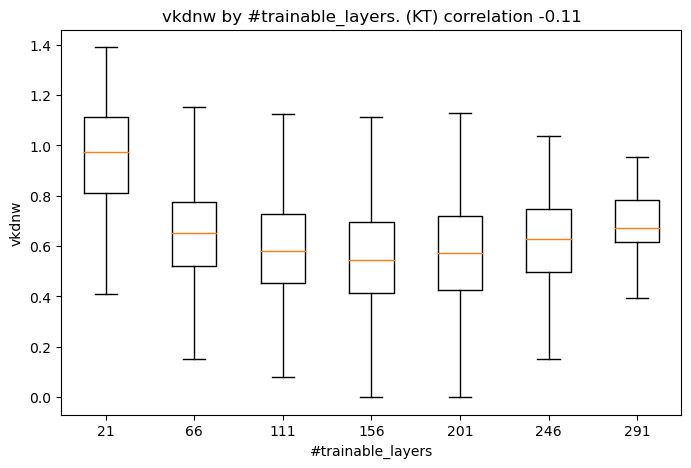

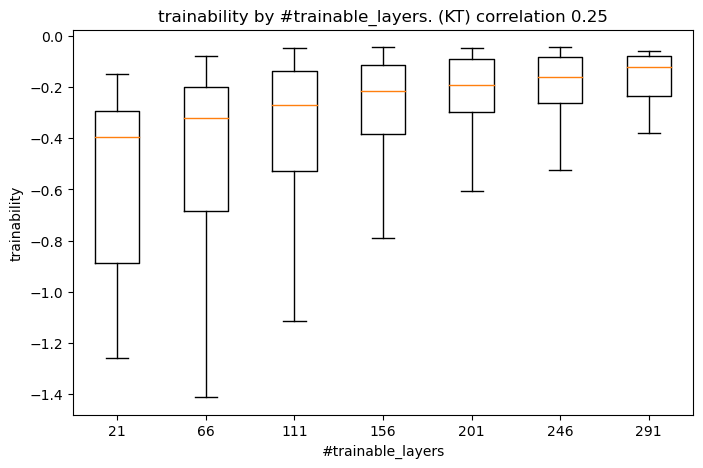

/home/tyblondr/.conda/envs/VKDNW/lib/python3.8/site-packages/numpy/lib/function_base.py:4573: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)


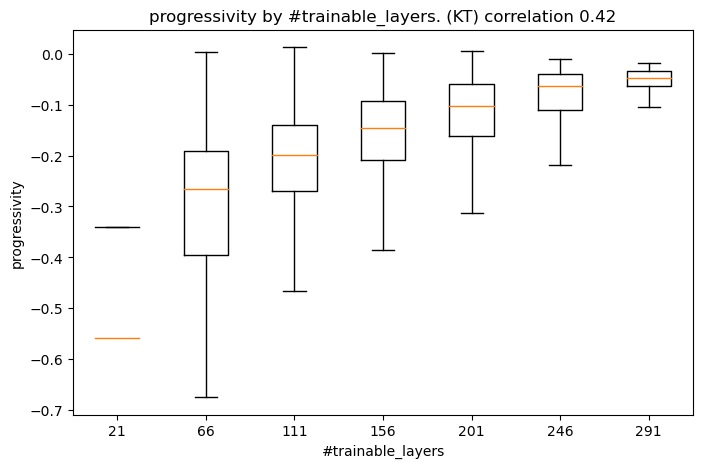

/home/tyblondr/.conda/envs/VKDNW/lib/python3.8/site-packages/numpy/lib/function_base.py:4573: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)


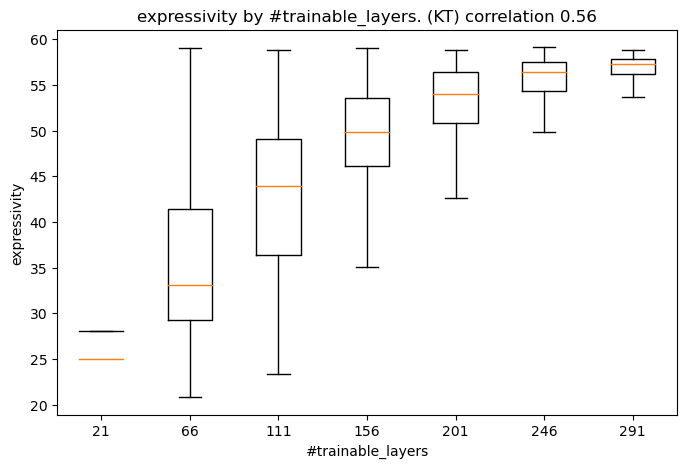

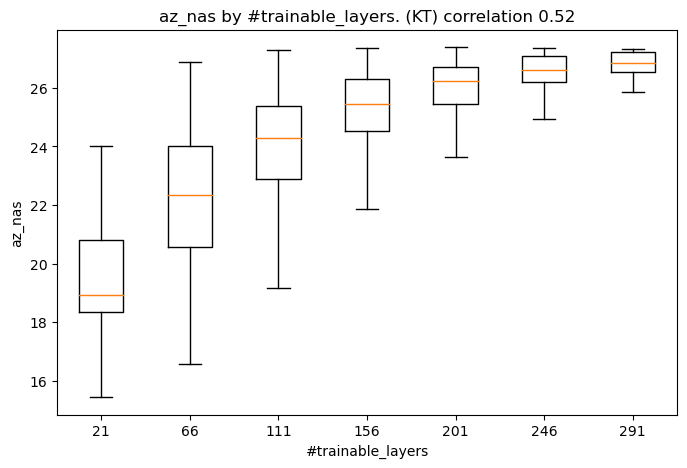

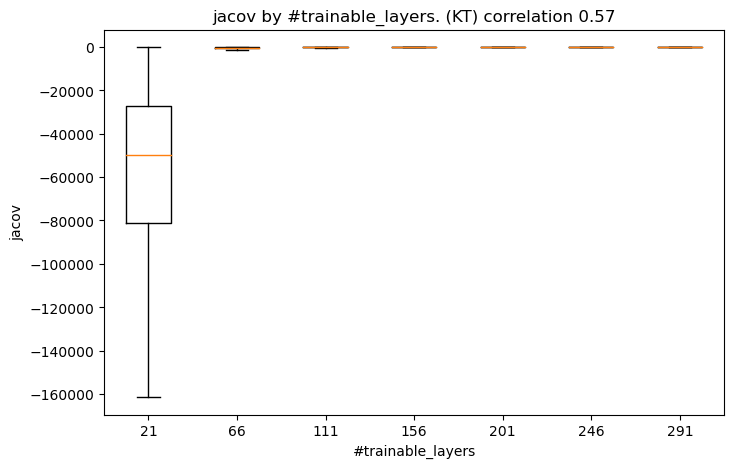

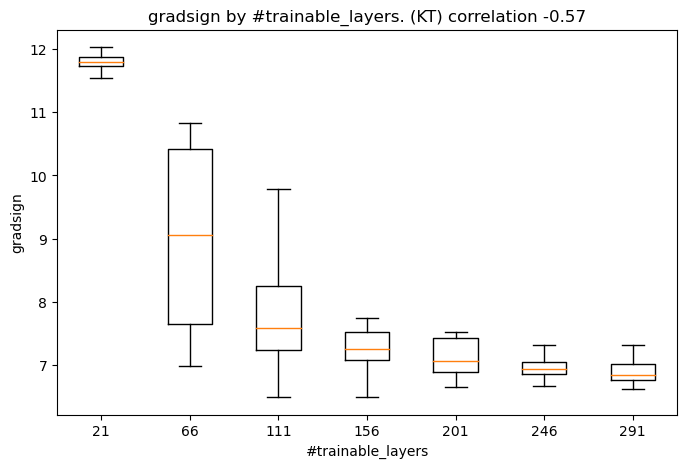

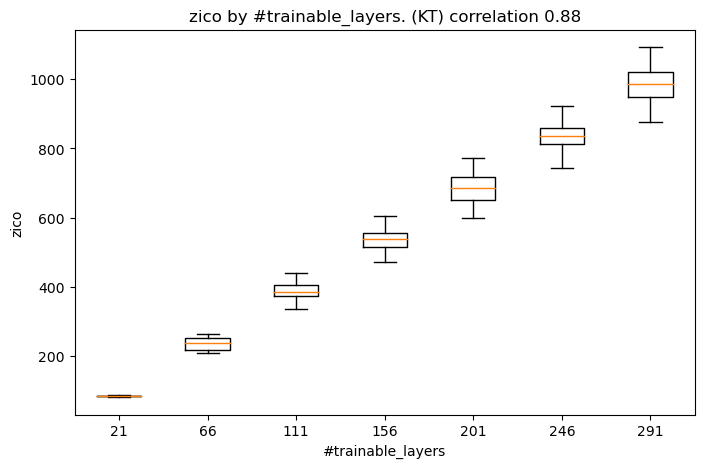

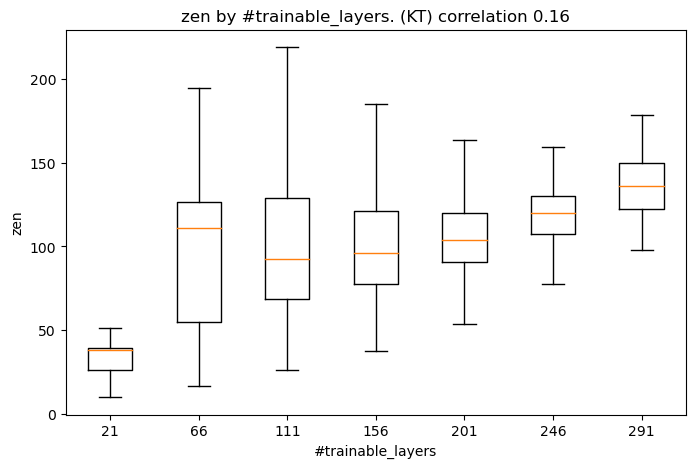

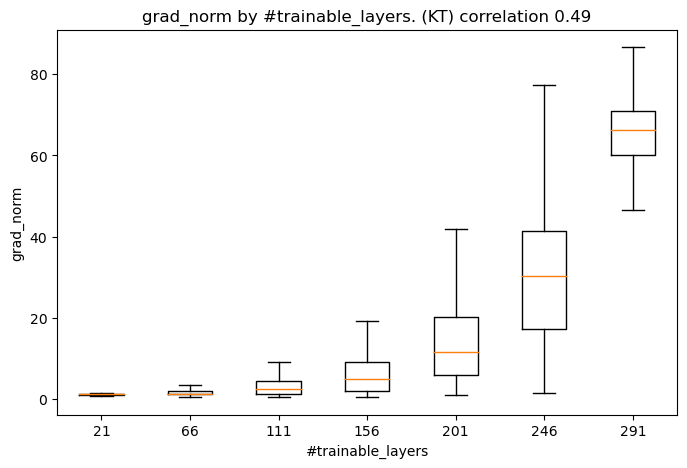

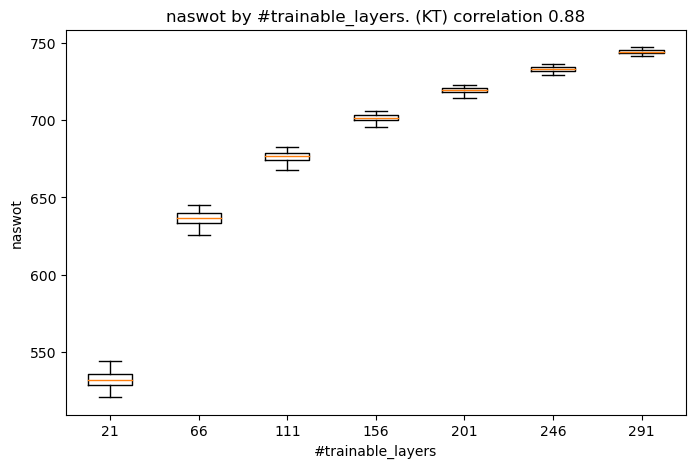

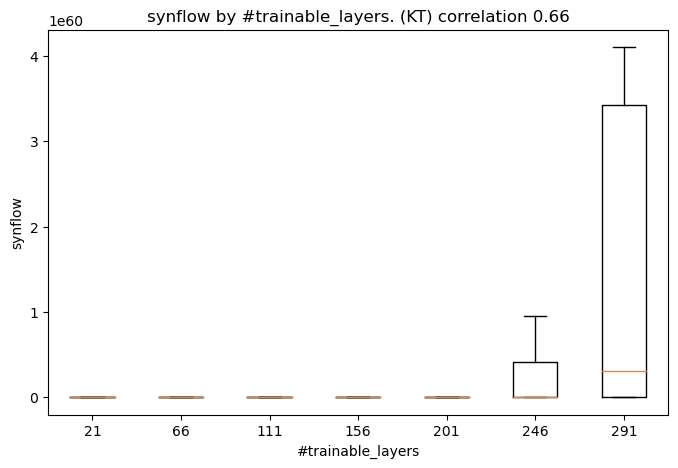

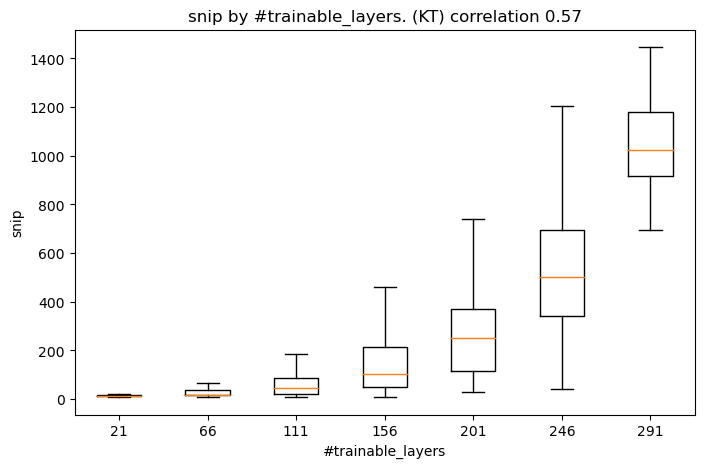

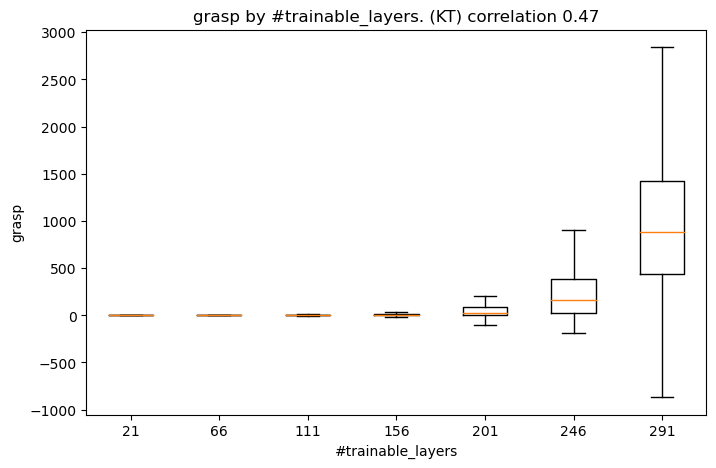

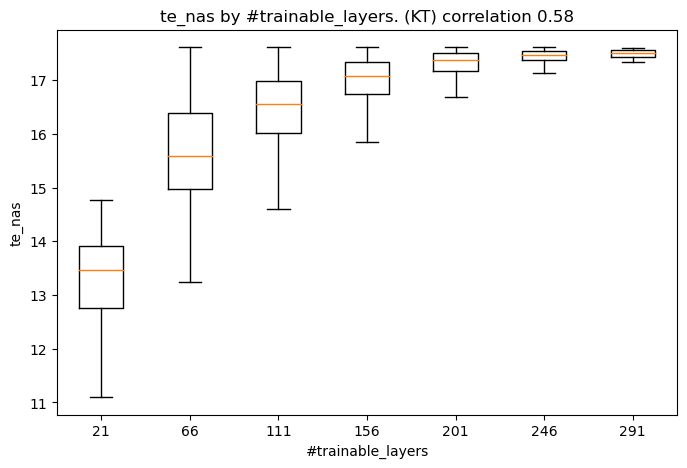

In [30]:
import wandb
import numpy as np
import matplotlib.pyplot as plt
api_wandb = wandb.Api()
run = pd.DataFrame(api_wandb.run('nazderaze/VKDNW/ss2kwvpp').scan_history())
from scipy.stats import kendalltau
from nats_bench import create
from tss_utils import generate_accs
import os
import pandas as pd
dataset = 'ImageNet16-120'
compute_graf = True

api_nats = create('/mnt/personal/tyblondr/NATS-tss-v1_0-3ffb9-simple/', 'tss', fast_mode=True, verbose=False)

if os.path.exists(f"./tss_features_{dataset}.pickle"):
    archs = pd.read_pickle(f"./tss_features_{dataset}.pickle")
else:
    archs = generate_accs(api_nats, dataset=dataset)
    print(f'No. of generated archs: {archs.shape[0]}')
    archs.to_pickle(f"./tss_features_{dataset}.pickle")


run.rename({'arch': 'net_str'}, axis=1, inplace=True)
run = pd.merge(archs, run, on='net_str', how='inner')
if compute_graf:
        run = run.loc[run['net'].notnull(), :]

run['jacov'] = run['jacov'].astype(float)
run['trainability'] = run['trainability'].astype(float)
run['progressivity'] = run['progressivity'].astype(float)
run['expressivity'] = run['expressivity'].astype(float)
run.loc[run['jacov'].isnull(), 'jacov'] = run['jacov'].min()
run['te_nas'] = run['linear_region'].rank().apply(np.log)+run['ntk'].rank().apply(np.log)
run['az_nas'] = run['trainability'].rank().apply(np.log)+run['progressivity'].rank().apply(np.log)+run['expressivity'].rank().apply(np.log)
for pred in ['vkdnw_entropy', 'trainability', 'progressivity', 'expressivity', 'az_nas', 'jacov','gradsign', 'zico', 'zen', 'grad_norm', 'naswot', 'synflow', 'snip', 'grasp', 'te_nas']:

    run[pred] = run[pred].astype(float)
    data_to_plot = [run[pred][run['vkdnw_dim'] == cat] for cat in run['vkdnw_dim'].unique()]
    kt = kendalltau(run['vkdnw_dim'], run[pred]).statistic
    
    plt.figure(figsize=(8, 5))    
    plt.boxplot(data_to_plot, labels=run['vkdnw_dim'].unique(), showfliers=False)
    if pred == 'vkdnw_entropy':
        plt.title(f"vkdnw by #trainable_layers. (KT) correlation {kt:.2f}")
        plt.xlabel('#trainable_layers')
        plt.ylabel('vkdnw')
        plt.savefig(f'ImageNet16-120_filtered_num_params_boxplot_vkdnw.eps', format='eps')
    else:
        plt.title(f"{pred} by #trainable_layers. (KT) correlation {kt:.2f}")
        plt.xlabel('#trainable_layers')
        plt.ylabel(pred)
        plt.savefig(f'ImageNet16-120_filtered_num_params_boxplot_{pred}.eps', format='eps')
    plt.show()

# Table 1 + Figure 1

In [11]:
import pandas as pd
import glob
import matplotlib.pyplot as plt

In [12]:
table_struct = [
    ('kendall_mean', 'cifar10'),
    ('spearman_mean', 'cifar10'),
    ('ndcg1000_mean', 'cifar10'),
    ('kendall_mean', 'cifar100'),
    ('spearman_mean', 'cifar100'),
    ('ndcg1000_mean', 'cifar100'),
    ('kendall_mean', 'ImageNet16-120'),
    ('spearman_mean', 'ImageNet16-120'),
    ('ndcg1000_mean', 'ImageNet16-120'),
]

In [13]:
data_all = pd.concat([pd.read_csv(file) for file in glob.glob('*_log.csv')], ignore_index=True)
data_all = data_all.loc[data_all['archs_filtered_']=='filtered', :]
data_all = data_all.loc[(data_all['train_size_'].isnull()) | (data_all['train_size_']==1024), :]
data_all['train_size_'].unique()
table1 = data_all[['pred_name_', 'dataset_', 'kendall_mean', 'spearman_mean', 'ndcg50_mean', 'ndcg1000_mean', 'ndcg5000_mean',]].pivot(index='pred_name_', columns=['dataset_'], values=['kendall_mean', 'spearman_mean', 'ndcg50_mean', 'ndcg1000_mean', 'ndcg5000_mean',])

In [14]:
table1_formatted = table1.loc[['vkdnw_dim_rank', 'flops_rank', 'grad_norm_rank', 'grasp_rank', 'snip_rank', 'synflow_rank', 'naswot_rank', 'te_nas_rank', 'zen_rank', 'gradsign_rank', 'zico_rank', 'jacov_rank', 'az_nas_rank', 'vkdnw_rank', 'vkdnw_comb_rank', 'pred_model_graf', 'pred_model_vkdnw', 'pred_model_vkdnw+zs', 'pred_model_vkdnw+zs+graf'], table_struct].applymap(lambda x: f"{x:.3f}")

table1_formatted.columns = ['_'.join(col) for col in table1_formatted.columns]
table1_formatted.index = table1_formatted.index.str.replace('_rank', '', regex=False)
table1_formatted.index = table1_formatted.index.str.replace('pred_', '', regex=False)
table1_formatted.to_latex()

'\\begin{tabular}{llllllllll}\n\\toprule\n & kendall_mean_cifar10 & spearman_mean_cifar10 & ndcg1000_mean_cifar10 & kendall_mean_cifar100 & spearman_mean_cifar100 & ndcg1000_mean_cifar100 & kendall_mean_ImageNet16-120 & spearman_mean_ImageNet16-120 & ndcg1000_mean_ImageNet16-120 \\\\\npred_name_ &  &  &  &  &  &  &  &  &  \\\\\n\\midrule\nvkdnw_dim & 0.626 & 0.767 & 0.671 & 0.646 & 0.787 & 0.525 & 0.623 & 0.764 & 0.497 \\\\\nflops & 0.623 & 0.799 & 0.745 & 0.586 & 0.763 & 0.576 & 0.545 & 0.718 & 0.403 \\\\\ngrad_norm & 0.328 & 0.438 & 0.509 & 0.341 & 0.451 & 0.278 & 0.310 & 0.418 & 0.265 \\\\\ngrasp & 0.352 & 0.505 & 0.518 & 0.349 & 0.498 & 0.284 & 0.359 & 0.502 & 0.281 \\\\\nsnip & 0.431 & 0.591 & 0.513 & 0.440 & 0.597 & 0.286 & 0.389 & 0.521 & 0.286 \\\\\nsynflow & 0.561 & 0.758 & 0.709 & 0.553 & 0.750 & 0.594 & 0.531 & 0.719 & 0.511 \\\\\nnaswot & 0.571 & 0.762 & 0.607 & 0.607 & 0.799 & 0.475 & 0.605 & 0.794 & 0.490 \\\\\nte_nas & 0.536 & 0.722 & 0.602 & 0.537 & 0.723 & 0.327 & 0.52

In [5]:
table1_formatted[['ndcg1000_mean_cifar10', 'ndcg1000_mean_cifar100', 'ndcg1000_mean_ImageNet16-120']]

,ndcg1000_mean_cifar10,ndcg1000_mean_cifar100,ndcg1000_mean_ImageNet16-120
pred_name_,,,
vkdnw_dim,0.681,0.530,0.477
flops,0.731,0.568,0.397
grad_norm,0.509,0.278,0.265
grasp,0.518,0.284,0.281
snip,0.513,0.286,0.286
synflow,0.709,0.594,0.511
naswot,0.607,0.475,0.490
te_nas,0.602,0.327,0.330
zen,0.120,0.115,0.073


In [6]:
table1_formatted

,kendall_mean_cifar10,spearman_mean_cifar10,ndcg1000_mean_cifar10,kendall_mean_cifar100,spearman_mean_cifar100,ndcg1000_mean_cifar100,kendall_mean_ImageNet16-120,spearman_mean_ImageNet16-120,ndcg1000_mean_ImageNet16-120
pred_name_,,,,,,,,,
vkdnw_dim,0.526,0.722,0.681,0.539,0.737,0.530,0.512,0.707,0.477
flops,0.581,0.782,0.731,0.549,0.748,0.568,0.509,0.700,0.397
grad_norm,0.328,0.438,0.509,0.341,0.451,0.278,0.310,0.418,0.265
grasp,0.352,0.505,0.518,0.349,0.498,0.284,0.359,0.502,0.281
snip,0.431,0.591,0.513,0.440,0.597,0.286,0.389,0.521,0.286
synflow,0.561,0.758,0.709,0.553,0.750,0.594,0.531,0.719,0.511
naswot,0.571,0.762,0.607,0.607,0.799,0.475,0.605,0.794,0.490
te_nas,0.536,0.722,0.602,0.537,0.723,0.327,0.523,0.709,0.330
zen,0.102,0.103,0.120,0.079,0.072,0.115,0.091,0.109,0.073


In [12]:
df_plot1

,pred_name_,ndcg1000_mean_ImageNet16-120
0,zen,0.073
1,grad_norm,0.265
2,grasp,0.281
3,snip,0.286
4,te_nas,0.330
5,jacov,0.356
6,flops,0.403
7,naswot,0.490
8,vkdnw_dim,0.511
9,synflow,0.511


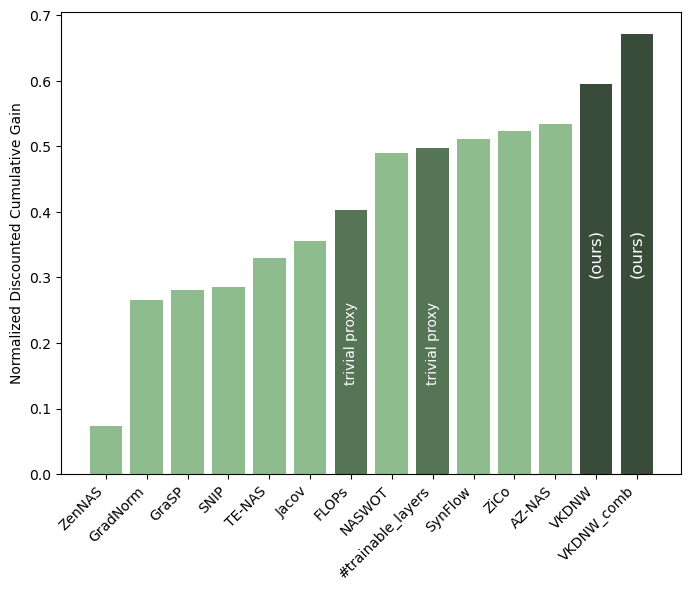

In [15]:
for plot_dataset in ['ImageNet16-120']:

    df_plot1 = table1_formatted[[f'ndcg1000_mean_{plot_dataset}']].astype(float)
    df_plot1 = df_plot1.loc[['vkdnw_comb', 'vkdnw_dim', 'flops', 'vkdnw', 'jacov', 'az_nas', 'zico', 'synflow', 'naswot', 'te_nas', 'snip', 'grasp', 'grad_norm', 'zen']].sort_values(f'ndcg1000_mean_{plot_dataset}')
    df_plot1 = df_plot1.reset_index()
    
    plt.figure(figsize=(8, 6))
    colors = ['#8FBC8F', '#8FBC8F', '#8FBC8F', '#8FBC8F', '#8FBC8F', '#8FBC8F', '#567556', '#8FBC8F', '#567556', '#8FBC8F', '#8FBC8F', '#8FBC8F', '#394B39', '#394B39']
    plt.bar(df_plot1['pred_name_'], df_plot1[f'ndcg1000_mean_{plot_dataset}'], color=colors)
    plt.ylabel('Normalized Discounted Cumulative Gain')
    
    plt.xticks(ticks=range(len(df_plot1['pred_name_'])), rotation=45, ha='right', labels=['ZenNAS', 'GradNorm', 'GraSP', 'SNIP', 'TE-NAS', 'Jacov', 'FLOPs', 'NASWOT', '#trainable_layers', 'SynFlow', 'ZiCo', 'AZ-NAS', 'VKDNW', 'VKDNW_comb'])
    #plt.text(14, 0.675, '(ours)', fontsize=12, ha='center', va='bottom', color='black')
    #plt.text(12, 0.6, '(ours)', fontsize=12, ha='center', va='bottom', color='black')
    
    plt.text(13, 0.3, '(ours)', fontsize=12, rotation=90, ha='center', va='bottom', color='white')
    plt.text(12, 0.3, '(ours)', fontsize=12, rotation=90, ha='center', va='bottom', color='white')
    
    plt.text(6, 0.2, "trivial proxy", rotation=90, va='center', ha='center', color='white')
    plt.text(8, 0.2, "trivial proxy", rotation=90, va='center', ha='center', color='white')
    plt.savefig(f'{plot_dataset}_filtered_figure1.eps', format='eps', bbox_inches='tight')
    plt.show()

In [31]:
"""
std = table1_formatted.loc[table1_formatted.index=='vkdnw_dim', f'ndcg1000_mean_{plot_dataset}'].astype(float).item()
plt.axhline(y=std, color='r', linestyle='--', linewidth=1.5, label='baseline')
plt.annotate('', 
             xy=(0, std+0.1), xycoords='data',  # Start position (category 2, y=10)
             xytext=(0, std), textcoords='data',  # End position (category 2, y=12)
             horizontalalignment='center',  # Centers the text horizontally
             arrowprops=dict(facecolor='green', edgecolor='green', arrowstyle='-|>', lw=1),
             fontsize=20, color='green')
    plt.text(2, std+0.05, 'Good rankings', fontsize=12, ha='center', va='bottom', color='green')
    plt.annotate('', 
             xy=(0, std-0.1), xycoords='data',  # Start position (category 1, y=10)
             xytext=(0, std), textcoords='data',  # End position (category 1, y=8)
             horizontalalignment='center',  # Centers the text horizontally
             arrowprops=dict(facecolor='red', edgecolor='red', arrowstyle='-|>', lw=1),
             fontsize=20, color='red')
    plt.text(2, std-0.05, 'Bad rankings', fontsize=12, ha='center', va='bottom', color='red')
"""

"\nstd = table1_formatted.loc[table1_formatted.index=='vkdnw_dim', f'ndcg1000_mean_{plot_dataset}'].astype(float).item()\nplt.axhline(y=std, color='r', linestyle='--', linewidth=1.5, label='baseline')\nplt.annotate('', \n             xy=(0, std+0.1), xycoords='data',  # Start position (category 2, y=10)\n             xytext=(0, std), textcoords='data',  # End position (category 2, y=12)\n             horizontalalignment='center',  # Centers the text horizontally\n             arrowprops=dict(facecolor='green', edgecolor='green', arrowstyle='-|>', lw=1),\n             fontsize=20, color='green')\n    plt.text(2, std+0.05, 'Good rankings', fontsize=12, ha='center', va='bottom', color='green')\n    plt.annotate('', \n             xy=(0, std-0.1), xycoords='data',  # Start position (category 1, y=10)\n             xytext=(0, std), textcoords='data',  # End position (category 1, y=8)\n             horizontalalignment='center',  # Centers the text horizontally\n             arrowprops=dict(f

# Ablation: add components

In [15]:
target = 'val_accs'
dataset = 'cifar100'
compute_graf = True
compute_graf_str = 'filtered' if compute_graf else 'unfiltered'
from nats_bench import create
from tss_utils import generate_accs
import os
import pandas as pd

In [16]:
api_nats = create('/mnt/personal/tyblondr/NATS-tss-v1_0-3ffb9-simple/', 'tss', fast_mode=True, verbose=False)

if os.path.exists(f"./tss_features_{dataset}.pickle"):
    archs = pd.read_pickle(f"./tss_features_{dataset}.pickle")
else:
    archs = generate_accs(api_nats, dataset=dataset)
    print(f'No. of generated archs: {archs.shape[0]}')
    archs.to_pickle(f"./tss_features_{dataset}.pickle")

In [17]:
run_dict = {
    'cifar10': {
        'nazderaze/VKDNW/k7llaf2s': 1,
        'nazderaze/VKDNW/knu2gv65': 2,
        'nazderaze/VKDNW/fnfbpspk': 3,
        'nazderaze/VKDNW/w4b39d0d': 4,
        'nazderaze/VKDNW/vbr5n8iy': 5
        
    },
    'cifar100': {
        'nazderaze/VKDNW/v2b816ul': 1,
        'nazderaze/VKDNW/velwxtxd': 2,
        'nazderaze/VKDNW/f3ljf5jf': 3,
        'nazderaze/VKDNW/e3w3dkv7': 4,
        'nazderaze/VKDNW/9ibvj04q': 5,
    },
    'ImageNet16-120': {
        'nazderaze/VKDNW/ss2kwvpp': 1,
        'nazderaze/VKDNW/es9t2696': 2,
        'nazderaze/VKDNW/m1dusbs9': 3,
        'nazderaze/VKDNW/kgmcpu2y': 4,
        'nazderaze/VKDNW/cpbmsvuw': 5,
    }
}

In [18]:
import wandb
import numpy as np
from sklearn.metrics import ndcg_score
api_wandb = wandb.Api()
from scipy.stats import kendalltau, spearmanr

log = None
for run_str, seed in run_dict[dataset].items():
    run = pd.DataFrame(api_wandb.run(run_str).scan_history())
    run.rename({'arch': 'net_str'}, axis=1, inplace=True)
    run = pd.merge(archs, run, on='net_str', how='inner')
    if compute_graf:
            run = run.loc[run['net'].notnull(), :]
        
    run['trainability'] = run['trainability'].astype(float)
    run['flops'] = run['flops'].astype(float)
    run['expressivity'] = run['expressivity'].astype(float)
    run['vkdnw_entropy'] = run['vkdnw_entropy'].astype(float)
    run['jacov'] = run['jacov'].astype(float)
    run.loc[run['jacov'].isnull(), 'jacov'] = run['jacov'].min()
    
    for flops in [True, False]:
        for expressivity in [True, False]:
            for trainability in [True, False]:
                for jacov in [True, False]:
                    for vkdnw in [True, False]:
                        run['score'] = 0
                        score_name = ''
                        if flops:
                            run['score'] += run['flops'].rank().apply(np.log)
                            score_name = score_name + 'flops_'
                        if expressivity:
                            run['score'] += run['expressivity'].rank().apply(np.log)
                            score_name = score_name + 'expressivity_'
                        if trainability:
                            run['score'] += run['trainability'].rank().apply(np.log)
                            score_name = score_name + 'trainability_'
                        if jacov:
                            run['score'] += run['jacov'].rank().apply(np.log)
                            score_name = score_name + 'jacov_'
                        if vkdnw:
                            run['score'] += run[['vkdnw_dim', 'vkdnw_entropy']].apply(tuple, axis=1).rank(method='dense', ascending=True).astype(int).apply(np.log)
                            score_name = score_name + 'vkdnw_'
                        if flops or expressivity or trainability or jacov or vkdnw:
                            gain = ndcg_score(y_true=2**np.array([run[target].astype(float)])-1,
                                   y_score=np.array([run['score'].astype(float)]), k=1000)
                            kt = kendalltau(run[target].astype(float), run['score'].astype(float)).statistic
                            spr = spearmanr(run[target].astype(float), run['score'].astype(float)).statistic
                            if log is None:
                                log = pd.DataFrame({'pred_name': [score_name], 'gain': [gain], 'seed': [seed], 'kt': [kt], 'spr': [spr]})
                            else:
                                log = pd.concat([log, pd.DataFrame({'pred_name': [score_name], 'gain': [gain], 'seed': [seed], 'kt': [kt], 'spr': [spr]})], ignore_index=True)
log = log.groupby('pred_name').mean()
log = log.reset_index()
log['dataset'] = dataset

/home/tyblondr/.conda/envs/VKDNW/lib/python3.8/site-packages/sklearn/utils/_array_api.py:245: RuntimeWarning: invalid value encountered in cast
  return x.astype(dtype, copy=copy, casting=casting)
/home/tyblondr/.conda/envs/VKDNW/lib/python3.8/site-packages/sklearn/utils/_array_api.py:245: RuntimeWarning: invalid value encountered in cast
  return x.astype(dtype, copy=copy, casting=casting)
/home/tyblondr/.conda/envs/VKDNW/lib/python3.8/site-packages/sklearn/utils/_array_api.py:245: RuntimeWarning: invalid value encountered in cast
  return x.astype(dtype, copy=copy, casting=casting)
/home/tyblondr/.conda/envs/VKDNW/lib/python3.8/site-packages/sklearn/utils/_array_api.py:245: RuntimeWarning: invalid value encountered in cast
  return x.astype(dtype, copy=copy, casting=casting)
/home/tyblondr/.conda/envs/VKDNW/lib/python3.8/site-packages/sklearn/utils/_array_api.py:245: RuntimeWarning: invalid value encountered in cast
  return x.astype(dtype, copy=copy, casting=casting)
/home/tyblondr/

In [19]:
#log_imagenet = log
#log_cifar10 = log
log_cifar100 = log

In [34]:
log = pd.merge(log_cifar10[['pred_name', 'gain', 'dataset']], log_cifar100[['pred_name', 'gain', 'dataset']], on='pred_name', how='left', suffixes=('_C10', '_C100'))
log = pd.merge(log, log_imagenet[['pred_name', 'gain', 'dataset']], on='pred_name', how='left', suffixes=('', '_IN'))
log = log[['pred_name', 'gain_C10', 'gain_C100', 'gain']]
log = log.style.format(decimal=',', thousands='.', precision=3)

print(log.to_latex())

\begin{tabular}{llrrr}
 & pred_name & gain_C10 & gain_C100 & gain \\
0 & expressivity_ & 0,622 & 0,336 & 0,277 \\
1 & expressivity_jacov_ & 0,631 & 0,387 & 0,361 \\
2 & expressivity_jacov_vkdnw_ & 0,719 & 0,520 & 0,524 \\
3 & expressivity_trainability_ & 0,677 & 0,464 & 0,463 \\
4 & expressivity_trainability_jacov_ & 0,697 & 0,498 & 0,530 \\
5 & expressivity_trainability_jacov_vkdnw_ & 0,727 & 0,565 & 0,626 \\
6 & expressivity_trainability_vkdnw_ & 0,727 & 0,564 & 0,604 \\
7 & expressivity_vkdnw_ & 0,725 & 0,505 & 0,483 \\
8 & flops_ & 0,743 & 0,576 & 0,403 \\
9 & flops_expressivity_ & 0,741 & 0,525 & 0,435 \\
10 & flops_expressivity_jacov_ & 0,750 & 0,546 & 0,491 \\
11 & flops_expressivity_jacov_vkdnw_ & 0,773 & 0,585 & 0,553 \\
12 & flops_expressivity_trainability_ & 0,782 & 0,610 & 0,629 \\
13 & flops_expressivity_trainability_jacov_ & 0,780 & 0,615 & 0,652 \\
14 & flops_expressivity_trainability_jacov_vkdnw_ & 0,786 & 0,634 & 0,671 \\
15 & flops_expressivity_trainability_vkdnw_ & 0

In [32]:
log

,pred_name,gain_C10,dataset_C10,gain_C100,dataset_C100,gain,dataset
0,expressivity_,0.621736,cifar10,0.336051,cifar100,0.276717,ImageNet16-120
1,expressivity_jacov_,0.630897,cifar10,0.387465,cifar100,0.361349,ImageNet16-120
2,expressivity_jacov_vkdnw_,0.718907,cifar10,0.519697,cifar100,0.524313,ImageNet16-120
3,expressivity_trainability_,0.677267,cifar10,0.463564,cifar100,0.462518,ImageNet16-120
4,expressivity_trainability_jacov_,0.696977,cifar10,0.497960,cifar100,0.529871,ImageNet16-120
5,expressivity_trainability_jacov_vkdnw_,0.726881,cifar10,0.565269,cifar100,0.626138,ImageNet16-120
6,expressivity_trainability_vkdnw_,0.727340,cifar10,0.563700,cifar100,0.603690,ImageNet16-120
7,expressivity_vkdnw_,0.724636,cifar10,0.504580,cifar100,0.482949,ImageNet16-120
8,flops_,0.743144,cifar10,0.576312,cifar100,0.403062,ImageNet16-120
9,flops_expressivity_,0.740639,cifar10,0.524972,cifar100,0.435473,ImageNet16-120
